In [5]:
import os
import corner
import jetsimpy
import numpy as np
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt

np.random.seed(12)

file = "/home/growth/Documents/GRB250704B/mcmc_df.csv"
data = pd.read_csv(file)
required_columns = ["Times", "Freqs", "Fluxes", "FluxErrs"]
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"Input CSV file is missing required columns: {required_columns}")
data = data[data["Fluxes"] > 0]  # taking detections only
if len(data) == 0:
    print("len of the input data is zero")

# input data -- check time in days or sec
obs_time = data["Times"]  # time in days
obs_nu = data["Freqs"].apply(lambda x: int(round(float(x))))  # in Hz
obs_flux = data["Fluxes"]  # in mJy
obs_flux_err = data["FluxErrs"]  # in mJy
print(max(obs_time))


In [6]:
# define basename with dir
file = "/home/growth/Documents/GRB250704B/mcmc_df.csv"
basedir = f"{os.path.dirname(file)}/multinest/"
label = "spowerlaw_epse"
outputfiles_basename = basedir + f"/GRB_04B_mcmc_{label}_"

# free parameters
# param_names = ["loge0", "logepsb", "logn0", "thc", "thv", "p"]
param_names = ["loge0", "logepsb", "logepse", "logn0", "thc", "thv", "p"]
n_params = len(param_names)

# labels
labels = [
    r"$\log_{10}(E_{K,iso})$",
    r"$\log_{10}(\epsilon_{b})$",
    r"$\log_{10}(\epsilon_{e})$",
    r"$\log_{10}(n_0)$",
    r"$\theta_{c}$",
    r"$\theta_{v}$",
    r"$p$",
]

a = pymultinest.Analyzer(outputfiles_basename=outputfiles_basename, n_params=n_params)
flat_samples = a.get_equal_weighted_posterior()[:, :-1]
medians = np.median(flat_samples, axis=0)

"""
fig = corner.corner(
    flat_samples,
    labels=labels,
    show_titles=True,
    truths=medians,
    title_fmt=".2f",
    title_kwargs={"fontsize": 13},
    # add smooth
    smooth=2,
    quantiles=[0.16, 0.5, 0.84],
    label_kwargs={"fontsize": 18},
    hist_kwargs={"density": True, "alpha": 0.5},
)
# fig.set_size_inches(10, 10)
# save the figure
plt.savefig(
    "/home/growth/Desktop/corner_plot.png",
    dpi=300,
    format="png",
    bbox_inches="tight",
)
"""

In [8]:
# PowerLaw
def model(obs_time, obs_nu, params, z):
    spread_bool = True  # spread
    dl = cosmo.luminosity_distance(z).to("Mpc").value
    P = dict(
        eps_e=10 ** params["logepse"],
        eps_b=10 ** params["logepsb"],
        p=params["p"],
        theta_v=params["thv"],  # params["thv"], #2.735
        d=dl,
        z=z,
    )

    jet_P = dict(
        Eiso=10 ** params["loge0"],
        lf=1e100,  # no coasting phase
        theta_c=params["thc"],
        n0=10 ** params["logn0"],
        A=0,  # no wind
        s=params["s"],
    )

    model_dict = P | jet_P
    print(model_dict)

    jet = jetsimpy.Jet(
        jetsimpy.PowerLaw(
            jet_P["theta_c"], jet_P["Eiso"], lf0=jet_P["lf"], s=jet_P["s"]
        ),
        # jetsimpy.Gaussian(jet_P["theta_c"], jet_P["Eiso"], lf0=jet_P["lf"]),
        nwind=jet_P["A"],
        nism=jet_P["n0"],
        grid=jetsimpy.ForwardJetRes(jet_P["theta_c"], 129),
        # allow spread or not
        spread=spread_bool,
        tmin=10.0,
        tmax=3.2e9,
        tail=True,
        cal_level=1,
        rtol=1e-6,
        cfl=0.9,
    )

    model_flux = jet.FluxDensity(
        obs_time,  # [second]
        obs_nu,  # [Hz]
        P,
        model="sync",  # radiation model
        rtol=1e-3,  # integration tolerance
        max_iter=100,
        force_return=True,
    )
    return model_flux, model_dict


In [9]:
def convert_freq_to_sdss_filter(freq):
    """
    Convert frequency in Hz to SDSS filter band.
    """
    if freq <= 0.65e9:
        return "0.65_GHz"
    elif freq <= 1.3e9:
        return "1.3_GHz"
    elif freq <= 3e9:
        return "3_GHz"
    elif freq <= 6e9:
        return "6_GHz"
    elif freq <= 10e9:
        return "10_GHz"
    elif freq < 3.6e14:
        return "z"
    elif freq < 4.4e14:
        return "r"
    elif freq < 5.55e14:
        return "i"
    elif freq < 7.38e14:
        return "g"
    elif freq < 1e15:
        return "u"
    else:
        return "swift"

In [11]:
#file17 = "gw170817_radio_optical_afterglow.csv"
file17 = "data/GW170817.csv"
data17 = pd.read_csv(file17)
print(data17.describe())
print(data17)
data17.to_csv(
    "gw170817_radio_optical_afterglow_mod.csv",
    index=False,
)

              Times         Freqs        Fluxes      FluxErrs
count  5.400000e+01  5.400000e+01  5.400000e+01  5.400000e+01
mean   1.802976e+07  4.917693e+16  2.531172e-02  2.876701e-03
std    1.742682e+07  9.793156e+16  2.699813e-02  2.800102e-03
min    7.948800e+05  3.000000e+09  1.300000e-07  5.900000e-08
25%    4.754160e+06  3.000000e+09  4.875000e-05  1.450000e-05
50%    1.408320e+07  6.000000e+09  2.075000e-02  2.850000e-03
75%    2.358720e+07  5.060000e+14  4.170000e-02  4.100000e-03
max    8.104320e+07  2.410000e+17  9.730000e-02  1.130000e-02
         Times   Filt         Freqs        Fluxes      FluxErrs
0    1416960.0  3_GHz  3.000000e+09  1.870000e-02  6.300000e-03
1    1503360.0  3_GHz  3.000000e+09  1.510000e-02  3.900000e-03
2    1581120.0  3_GHz  3.000000e+09  1.450000e-02  3.700000e-03
3    1935360.0  3_GHz  3.000000e+09  2.250000e-02  3.400000e-03
4    2090880.0  3_GHz  3.000000e+09  2.560000e-02  2.900000e-03
5    2704320.0  3_GHz  3.000000e+09  3.400000e-02  3.60000

file17x = "gw170817_xray_afterglow.csv"
data17x = pd.read_csv(file17x)

data17x = data17x[
    data17x["Flux [1e-17W.m**-2] [1e-17W.m**-2]"] > 0
]  # taking detections only
if len(data17x) == 0:
    print("len of the input data is zero")

# input data -- check time in days or sec
obs_time17x = data17x["Date"] * 86400  # time sec
data17x["Freq [GHz]"] = (
    1e18  # in Hz, assuming frequency is constant for X-ray observations
)

data17x["Flux [1e-17W.m**-2] [1e-17W.m**-2]"] *= 1e-17 * 1e29 / 1e18
# in mJy # convert from W/m^2 to mJy

data17x["e_Flux [1e-17W.m**-2] [1e-17W.m**-2]"] *= (
    1e-17 * 1e29 / 1e18
)  # in mJy # convert from W/m^2 to mJy
data17x["Filt"] = "swift"  # assuming Swift X-ray observations
data17x = data17x.rename(
    columns={  # Times,Fluxes,FluxErrs,Filt,Freqs
        # DeltaT [d],Freq [GHz],Flux [uJy],e_Flux [uJy]
        "Flux [1e-17W.m**-2] [1e-17W.m**-2]": "Fluxes",
        "e_Flux [1e-17W.m**-2] [1e-17W.m**-2]": "FluxErrs",
        "DeltaT [d]": "Times",
        "Freq [GHz]": "Freqs",
    },
)
print(data17x.describe())
print(data17x.head())
data17 = pd.concat([data17, data17x], ignore_index=True)
print(data17.describe())
print(data17)

len times = 54
factors: 1, thetav_factor: 1, s_factor: 1
original parameters: {'jetType': 'powerlaw', 'loge0': 54.5, 'logepsb': -4.04, 'logepse': -3.3, 'logn0': -1.65, 'thc': 0.04258603374866164, 'thv': 0.3752457891787808, 'lf': 1e+100, 's': 9.41, 'p': 2.1193, 'z': 0.0099}
modified parameters: {'jetType': 'powerlaw', 'loge0': 54.5, 'logepsb': -4.04, 'logepse': -3.3, 'logn0': -1.65, 'thc': 0.04258603374866164, 'thv': 0.3752457891787808, 'lf': 1e+100, 's': 9.41, 'p': 2.1193, 'z': 0.0099}


KeyError: '1keV'

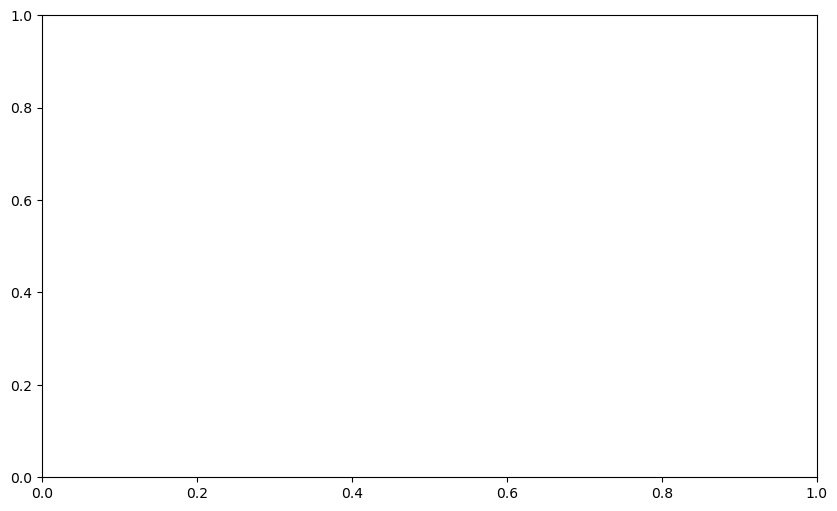

In [20]:
times = data17["Times"].values
print(f"len times = {len(times)}")
freq = dict(
    data17[["Filt", "Freqs"]]
    .drop_duplicates()
    .sort_values(by="Freqs", ascending=False)
    .to_numpy()
)
freq_dict = dict(freq)

shifts = {
    "swift": 1,
    "g": 1 / 8,
    "VT_B": 1 / 4,
    "r": 1,
    "i": 8,
    "z": 16,
    "J": 32,
    "10_GHz": 1500,
    "6_GHz": 400,
    "3_GHz": 100,
    "1.3_GHz": 100,
    "0.65_GHz": 50,
}

color_dict = {
    "swift": "tab:purple",
    "g": "tab:green",
    "r": "tab:red",
    "i": "gold",
    "z": "tab:orange",
    "J": "olive",
    "10_GHz": "skyblue",
    "6_GHz": "magenta",
    "3_GHz": "aqua",
    "1.3_GHz": "aqua",
    "0.65_GHz": "b",
}



params = {
    'jetType':'powerlaw',
    'loge0':54.5, 'logepsb':-4.04, 'logepse':-3.3, 'logn0':-1.65, 'thc':2.44*np.pi/180, 
    'thv':21.5*np.pi/180, 'lf':1e100,
    's':9.41, 'p':2.1193,
    'z':0.0099}
    #observed_data='data/GW170817.csv',
    #observed_data_fit='data/GW170817.csv'#)'data/mcmc_df_trunc.csv',)}


for theta_factor in [1]:
    for thetav_factor in [1]:  # [0.5, 1.0, 1.5, 2]:
        for s_factor in [1]:  # [0.75]:
            params_median_mod = params.copy()
            params_median_mod["thc"] *= theta_factor  # scale the core angle
            params_median_mod["thv"] *= theta_factor * thetav_factor
            params_median_mod["s"] *= s_factor  # scale the spread factor

            print(
                f"factors: {theta_factor}, thetav_factor: {thetav_factor}, s_factor: {s_factor}"
            )
            print(f"original parameters: {params}")
            print(f"modified parameters: {params_median_mod}")
            fig, ax = plt.subplots(figsize=(10, 6))
            for filt, freqs in freq_dict.items():
                # print(f"Filter: {filt}, Frequencies: {freqs}")
                data_filt = data17[data17["Filt"] == filt]
                obs_time = data_filt["Times"].values
                obs_flux = data_filt["Fluxes"].values
                obs_flux_err = data_filt["FluxErrs"].values
                # print(filt, obs_flux_err)

                ax.errorbar(
                    obs_time,
                    obs_flux, # * shifts[filt],
                    yerr=obs_flux_err, # * shifts[filt],
                    fmt="o",
                    label=f"{filt}",#Times,Filt,Freqs,Fluxes,FluxErrs

                    color=color_dict[filt],
                    markeredgecolor="k",
                )

                x_fit = np.logspace(2, 9, 50)
                med_flux, model_dict = model(x_fit, freqs, params_median_mod, z)
                ax.plot(
                    x_fit,
                    med_flux * shifts[filt],
                    # label=f"Model {filt}",
                    ls="--",
                    color=color_dict[filt],
                    # alpha=0.5,
                )
                # for param in params_list:
                #     Fnu, _ = model(x_fit, freqs, param, z)
                #     ax.plot(
                #         x_fit,
                #         Fnu * shifts[filt],
                #         ls="-",
                #         color=color_dict[filt],
                #         alpha=0.1,
                #     )
            ax.errorbar(1e6, 3e-7, fmt="v", label="chandra")

            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Flux (mJy)")
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.grid(True, linestyle="--", alpha=0.5)
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
            param_text = "\n".join([f"{k} = {v:.3g}" for k, v in model_dict.items()])
            ax.text(
                1.05,
                0.5,  # x,y position in axis coords (1.05 is just right of plot)
                param_text,
                transform=ax.transAxes,  # coords relative to axis
                fontsize=9,
                verticalalignment="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
            )
            ax = plt.gca()
            secax = ax.secondary_xaxis(
                "top", functions=(lambda x: x / 86400.0, lambda d: d * 86400.0)
            )
            secax.set_xlabel("Time (days)")

            plt.tight_layout()
            plt.show()

            """
            fig.savefig(
                "/home/growth/Desktop/modelled_lc.png",
                dpi=300,
                format="png",
                bbox_inches="tight",
            )
            """

len times = 101
factors: 1, thetav_factor: 1, s_factor: 1
original parameters: {'loge0': 54.168168243214666, 'logepsb': -2.0581032441172598, 'logepse': -0.6373441851859776, 'logn0': -1.8587174795380434, 'thc': 0.011578268507428435, 'thv': 0.03167209487957792, 'p': 2.0369630326344677, 's': 6.0}
modified parameters: {'loge0': 54.168168243214666, 'logepsb': -2.0581032441172598, 'logepse': -0.6373441851859776, 'logn0': -1.8587174795380434, 'thc': 0.011578268507428435, 'thv': 0.03167209487957792, 'p': 2.0369630326344677, 's': 6.0}
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.03167209487957792, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta_c': 0.011578268507428435, 'n0': 0.013844667196331718, 'A': 0, 's': 6.0}
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.03167209487957792, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, '

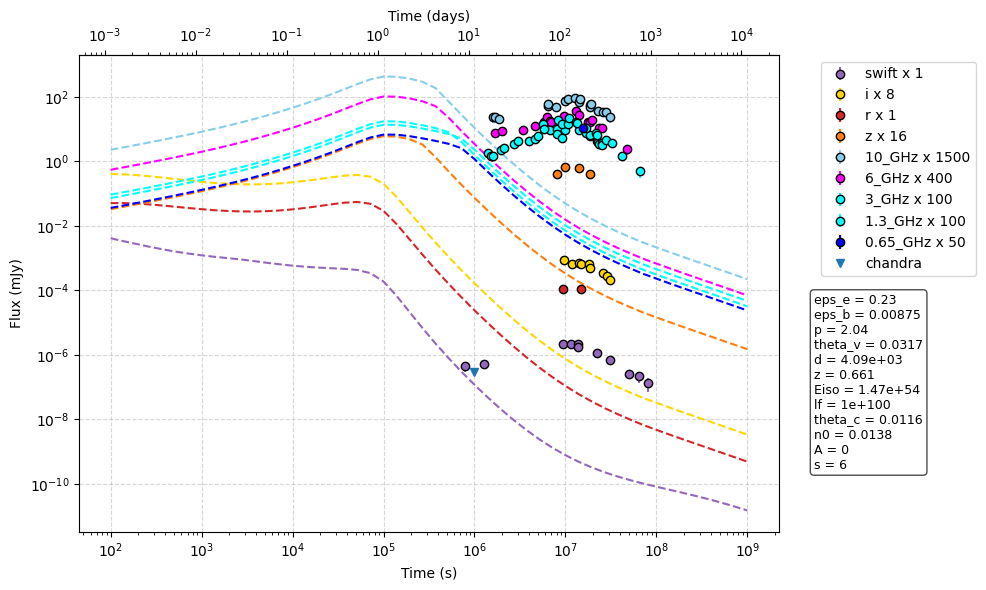

factors: 3, thetav_factor: 1, s_factor: 1
original parameters: {'loge0': 54.168168243214666, 'logepsb': -2.0581032441172598, 'logepse': -0.6373441851859776, 'logn0': -1.8587174795380434, 'thc': 0.011578268507428435, 'thv': 0.03167209487957792, 'p': 2.0369630326344677, 's': 6.0}
modified parameters: {'loge0': 54.168168243214666, 'logepsb': -2.0581032441172598, 'logepse': -0.6373441851859776, 'logn0': -1.8587174795380434, 'thc': 0.034734805522285306, 'thv': 0.09501628463873377, 'p': 2.0369630326344677, 's': 6.0}
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.09501628463873377, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta_c': 0.034734805522285306, 'n0': 0.013844667196331718, 'A': 0, 's': 6.0}
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.09501628463873377, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'th

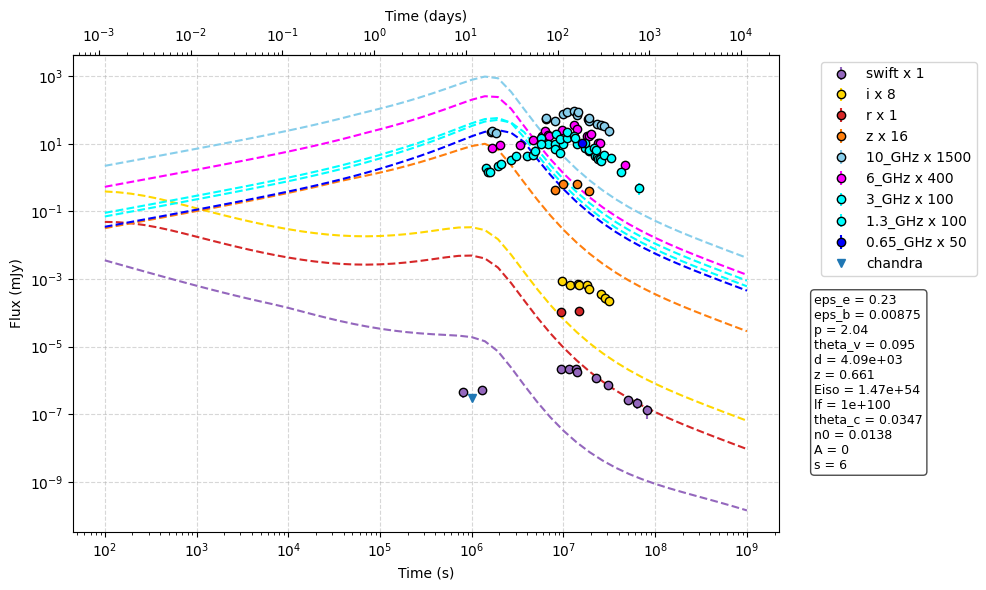

factors: 5, thetav_factor: 1, s_factor: 1
original parameters: {'loge0': 54.168168243214666, 'logepsb': -2.0581032441172598, 'logepse': -0.6373441851859776, 'logn0': -1.8587174795380434, 'thc': 0.011578268507428435, 'thv': 0.03167209487957792, 'p': 2.0369630326344677, 's': 6.0}
modified parameters: {'loge0': 54.168168243214666, 'logepsb': -2.0581032441172598, 'logepse': -0.6373441851859776, 'logn0': -1.8587174795380434, 'thc': 0.057891342537142176, 'thv': 0.1583604743978896, 'p': 2.0369630326344677, 's': 6.0}
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.1583604743978896, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta_c': 0.057891342537142176, 'n0': 0.013844667196331718, 'A': 0, 's': 6.0}
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.1583604743978896, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta

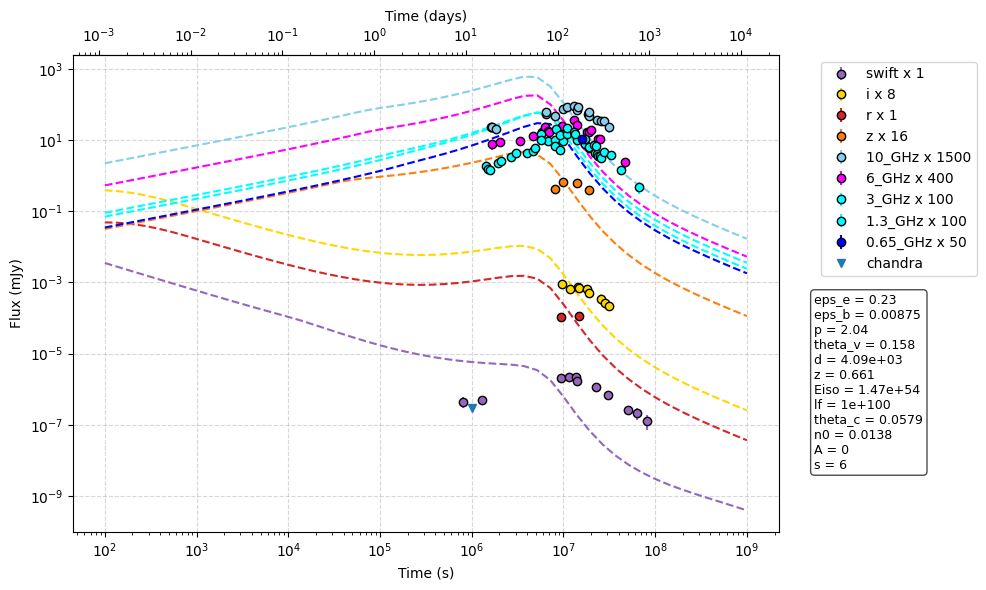

In [ ]:
times = data17["Times"].values
print(f"len times = {len(times)}")
freq = dict(
    data17[["Filt", "Freqs"]]
    .drop_duplicates()
    .sort_values(by="Freqs", ascending=False)
    .to_numpy()
)
freq_dict = dict(freq)

shifts = {
    "swift": 1,
    "g": 1 / 8,
    "VT_B": 1 / 4,
    "r": 1,
    "i": 8,
    "z": 16,
    "J": 32,
    "10_GHz": 1500,
    "6_GHz": 400,
    "3_GHz": 100,
    "1.3_GHz": 100,
    "0.65_GHz": 50,
}

color_dict = {
    "swift": "tab:purple",
    "g": "tab:green",
    "r": "tab:red",
    "i": "gold",
    "z": "tab:orange",
    "J": "olive",
    "10_GHz": "skyblue",
    "6_GHz": "magenta",
    "3_GHz": "aqua",
    "1.3_GHz": "aqua",
    "0.65_GHz": "b",
}

params_median["s"] = 6.0
for theta_factor in [1, 3, 5]:
    for thetav_factor in [1]:  # [0.5, 1.0, 1.5, 2]:
        for s_factor in [1]:  # [0.75]:
            params_median_mod = params_median.copy()
            params_median_mod["thc"] *= theta_factor  # scale the core angle
            params_median_mod["thv"] *= theta_factor * thetav_factor
            params_median_mod["s"] *= s_factor  # scale the spread factor

            print(
                f"factors: {theta_factor}, thetav_factor: {thetav_factor}, s_factor: {s_factor}"
            )
            print(f"original parameters: {params_median}")
            print(f"modified parameters: {params_median_mod}")
            fig, ax = plt.subplots(figsize=(10, 6))
            for filt, freqs in freq_dict.items():
                # print(f"Filter: {filt}, Frequencies: {freqs}")
                data_filt = data17[data17["Filt"] == filt]
                obs_time = data_filt["Times"].values
                obs_flux = data_filt["Fluxes"].values
                obs_flux_err = data_filt["FluxErrs"].values
                # print(filt, obs_flux_err)

                ax.errorbar(
                    obs_time,
                    obs_flux * shifts[filt],
                    yerr=obs_flux_err * shifts[filt],
                    fmt="o",
                    label=f"{filt} x {shifts[filt]}",
                    color=color_dict[filt],
                    markeredgecolor="k",
                )

                x_fit = np.logspace(2, 9, 50)
                med_flux, model_dict = model(x_fit, freqs, params_median_mod, z)
                ax.plot(
                    x_fit,
                    med_flux * shifts[filt],
                    # label=f"Model {filt}",
                    ls="--",
                    color=color_dict[filt],
                    # alpha=0.5,
                )
                # for param in params_list:
                #     Fnu, _ = model(x_fit, freqs, param, z)
                #     ax.plot(
                #         x_fit,
                #         Fnu * shifts[filt],
                #         ls="-",
                #         color=color_dict[filt],
                #         alpha=0.1,
                #     )
            ax.errorbar(1e6, 3e-7, fmt="v", label="chandra")

            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Flux (mJy)")
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.grid(True, linestyle="--", alpha=0.5)
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
            param_text = "\n".join([f"{k} = {v:.3g}" for k, v in model_dict.items()])
            ax.text(
                1.05,
                0.5,  # x,y position in axis coords (1.05 is just right of plot)
                param_text,
                transform=ax.transAxes,  # coords relative to axis
                fontsize=9,
                verticalalignment="top",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
            )
            ax = plt.gca()
            secax = ax.secondary_xaxis(
                "top", functions=(lambda x: x / 86400.0, lambda d: d * 86400.0)
            )
            secax.set_xlabel("Time (days)")

            plt.tight_layout()
            plt.show()

            """
            fig.savefig(
                "/home/growth/Desktop/modelled_lc.png",
                dpi=300,
                format="png",
                bbox_inches="tight",
            )
            """

In [ ]:
# 170817

2133984767.4813232


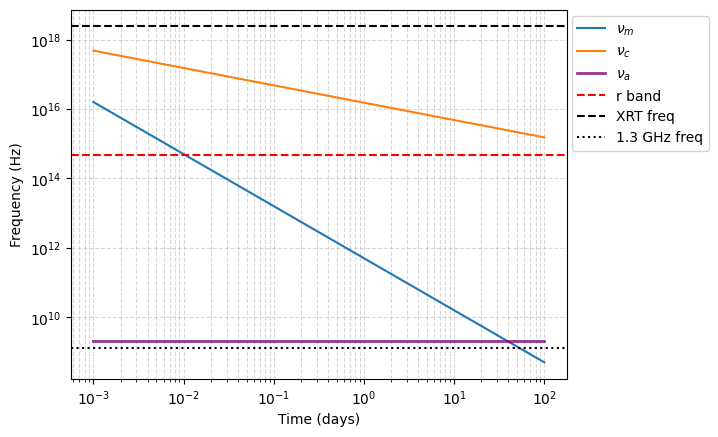

In [ ]:
def sync_freq_evolution(z, p, E52, epsilon_B, epsilon_e, n0):
    td = np.linspace(0.001, 100, 1000)  # in days
    nu_m = (
        5.1e15
        * (1 + z) ** 0.5
        * ((p - 2) / (p - 1)) ** 2
        * epsilon_e**2
        * epsilon_B**0.5
        * E52**0.5
        * td ** (-1.5)
    )  # Hz
    nu_c = (
        2.7e12
        * (1 + z) ** (-0.5)
        * epsilon_B ** (-1.5)
        * E52 ** (-0.5)
        * n0 ** (-1)
        * td ** (-0.5)
    )  # Hz
    nu_a = (
        1.24e9
        * (((p - 1) / (3 * p + 2)) ** (3 / 5))
        * (1 + z) ** (-1)
        * ((p - 2) / (p - 1)) ** (-1)
        * epsilon_e ** (-1)
        * epsilon_B ** (1 / 5)
        * n0 ** (3 / 5)
        * E52 ** (1 / 5)
    )
    print(nu_a)
    plt.plot(td, nu_m, label="$\\nu_m$")
    plt.plot(td, nu_c, label="$\\nu_c$")
    plt.plot(td, [nu_a] * len(td), label="$\\nu_a$", color="purple", lw=2, alpha=0.8)
    plt.axhline(4.8e14, color="r", linestyle="--", label="r band")
    plt.axhline(2.4179e18, color="k", linestyle="--", label="XRT freq")
    plt.axhline(1.3e9, color="k", linestyle="dotted", label="1.3 GHz freq")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Time (days)")
    plt.ylabel("Frequency (Hz)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.savefig(
        "/home/growth/Desktop/sync_freq_evolution.png",
        dpi=300,
        format="png",
        bbox_inches="tight",
    )
    # supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    return


z = 0.661
epsilon_e = 10 ** params_median["logepse"]
epsilon_B = 10 ** params_median["logepsb"]
n0 = 10 ** params_median["logn0"]
E52 = 10 ** params_median["loge0"] / 1e52
p = params_median["p"]
sync_freq_evolution(z, p, E52, epsilon_B, epsilon_e, n0)


## Final plot

In [ ]:
plt.style.use("default")


Filter: swift, Frequencies: 2.42e+17
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.03167209487957792, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta_c': 0.011578268507428435, 'n0': 0.013844667196331718, 'A': 0, 's': 6.0}
Filter: g, Frequencies: 628495719077568.1
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.03167209487957792, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta_c': 0.011578268507428435, 'n0': 0.013844667196331718, 'A': 0, 's': 6.0}
Filter: r, Frequencies: 481130569731985.2
{'eps_e': 0.2304919779627587, 'eps_b': 0.008747757914876475, 'p': 2.0369630326344677, 'theta_v': 0.03167209487957792, 'd': 4087.9949915089733, 'z': 0.661, 'Eiso': 1.4728829784230539e+54, 'lf': 1e+100, 'theta_c': 0.011578268507428435, 'n0': 0.013844667196331718, 'A': 0, 's': 6.0}
Filter: i, Frequencies: 393170436721311

/tmp/ipykernel_2959521/4218518485.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


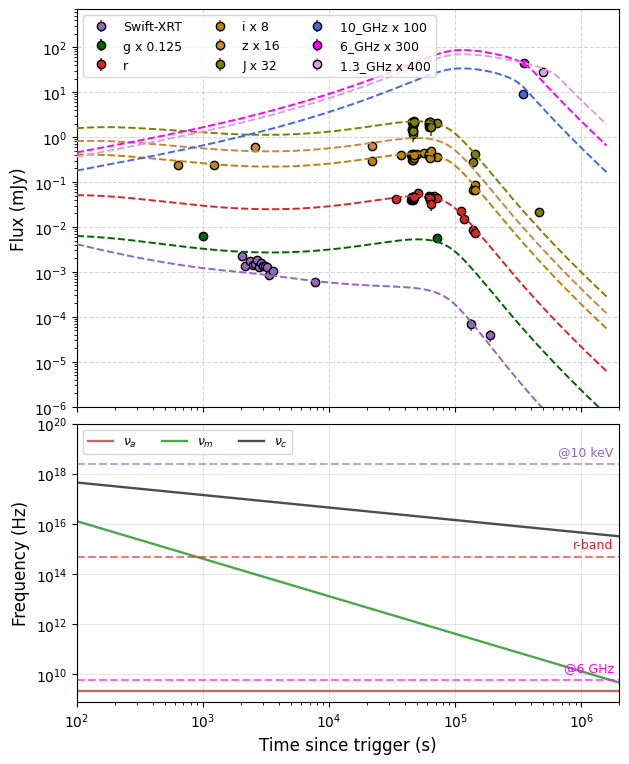

In [ ]:
from matplotlib import colors as mcolors

mcmc_df = pd.read_csv("/home/growth/Documents/GRB250704B/mcmc_df.csv")
times = mcmc_df["Times"].values
freq = dict(
    mcmc_df[["Filt", "Freqs"]]
    .drop_duplicates()
    .sort_values(by="Freqs", ascending=False)
    .to_numpy()
)
freq_dict = dict(freq)
del freq_dict["VT_B"]
del freq_dict["R"]
del freq_dict["VT_R"]
# del freq_dict["1.3_GHz"]

# del freq_dict["swift"]
# del freq_dict["g"]
# del freq_dict["i"]
# del freq_dict["r"]
# del freq_dict["z"]
# del freq_dict["J"]
# del freq_dict["10_GHz"]
# del freq_dict["6_GHz"]


shifts = {
    "swift": 1,
    "g": 1 / 8,
    "VT_B": 1 / 4,
    "r": 1,
    "i": 8,
    "z": 16,
    "J": 32,
    "10_GHz": 100,
    "1.3_GHz": 400,
    "6_GHz": 300,
    "0.65_GHz": 2000,
}

chain_dict = {
    "6_GHz": "plum",
    "swift": "lavender",
    "g": "mediumaquamarine",
    "r": "coral",  # "tab:red",
    "i": "khaki",
    "z": "peachpuff",
    "J": "tan",
    "10_GHz": "skyblue",
    "1.3_GHz": "plum",
    "0.65_GHz": "b",
}

color_dict = {
    "6_GHz": "magenta",
    "swift": "tab:purple",
    "g": "darkgreen",
    "r": "tab:red",  # "tab:red",
    "i": "darkgoldenrod",
    "z": "peru",
    "J": "olive",
    "10_GHz": "royalblue",
    "1.3_GHz": "plum",
    "0.65_GHz": "b",
}


x_min = 100
x_max = 2e6
y_min = 1e-6
y_max = 7e2


# fig, ax = plt.subplots(figsize=(6, 4.5))
fig, (ax, ax_freq) = plt.subplots(
    2,
    1,
    figsize=(7, 9),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 0.7], "hspace": 0.05},
)
for filt, freqs in freq_dict.items():
    print(f"Filter: {filt}, Frequencies: {freqs}")
    data_filt = mcmc_df[mcmc_df["Filt"] == filt]
    obs_time = data_filt["Times"].values
    obs_flux = data_filt["Fluxes"].values
    obs_flux_err = data_filt["FluxErrs"].values

    if shifts[filt] == 1:
        label = f"{filt}"
    else:
        label = f"{filt} x {shifts[filt]}"
    if filt == "swift":
        label = "Swift-XRT"

    x_fit = np.logspace(2, 6.2, 300)
    med_flux, model_dict = model(x_fit, freqs, params_median, z)
    # for param in params_list:
    #     Fnu, _ = model(x_fit, freqs, param, z)
    #     ax.plot(
    #         x_fit,
    #         Fnu * shifts[filt],
    #         ls="-",
    #         lw=0.6,
    #         color=chain_dict[filt],
    #         alpha=0.8,
    #     )

    ax.errorbar(
        obs_time,
        obs_flux * shifts[filt],
        yerr=obs_flux_err * shifts[filt],
        fmt="o",
        label=label,
        color=color_dict[filt],
        markeredgecolor="k",
    )
    ax.plot(
        x_fit,
        med_flux * shifts[filt],
        ls="--",
        color=color_dict[filt],
        lw=1.4,
        # alpha=1,
        zorder=5,
    )

# upper limit
# filt = "1.3_GHz"
# ax.errorbar(1171802.9, 0.05 * shifts[filt], fmt="v", color=color_dict[filt], markersize=5)


ax.set_ylabel("Flux (mJy)", fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.grid(True, linestyle="--", alpha=0.5)
# ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.legend(fontsize=9, ncol=3, loc="upper left")
param_text = "\n".join([f"{k} = {v:.3g}" for k, v in model_dict.items()])


td = np.linspace(x_min / 86400, x_max / 86400, 1000)  # in days
nu_m = (
    5.1e15
    * (1 + z) ** 0.5
    * ((p - 2) / (p - 1)) ** 2
    * epsilon_e**2
    * epsilon_B**0.5
    * E52**0.5
    * td ** (-1.5)
)  # Hz
nu_c = (
    2.7e12
    * (1 + z) ** (-0.5)
    * epsilon_B ** (-1.5)
    * E52 ** (-0.5)
    * n0 ** (-1)
    * td ** (-0.5)
)  # Hz

nu_a = (
    1.24e9
    * (((p - 1) / (3 * p + 2)) ** (3 / 5))
    * (1 + z) ** (-1)
    * ((p - 2) / (p - 1)) ** (-1)
    * epsilon_e ** (-1)
    * epsilon_B ** (1 / 5)
    * n0 ** (3 / 5)
    * E52 ** (1 / 5)
)

# ax_freq.plot(td, nu_m, label="$\\nu_m$")
# ax_freq.plot(td, nu_c, label="$\\nu_c$")

# Compute frequencies

# Plot frequency evolution
ax_freq.loglog(
    td * 86400, [nu_a] * len(td), label=r"$\nu_a$", lw=1.7, alpha=0.7, color="brown"
)
ax_freq.loglog(td * 86400, nu_m, label=r"$\nu_m$", lw=1.7, alpha=0.7, color="g")
ax_freq.loglog(td * 86400, nu_c, label=r"$\nu_c$", lw=1.7, alpha=0.7, color="black")

# Observing bands
# ax_freq.axhline(y=4.8e14, color='tab:red',
#                 linestyle='--', label=r'r', alpha=0.6)
# ax_freq.axhline(y=2.4e18, color="tab:purple", linestyle='--',
#                 label=r'@10 keV', alpha=0.6)
# ax_freq.axhline(y=1e10, color='teal', linestyle='--', label=r'@10 GHz', alpha=0.6)

# Observing bands
bands = [
    (4.8e14, "r-band", "tab:red"),
    (2.4e18, "@10 keV", "tab:purple"),
    (6e9, "@6 GHz", "magenta"),
]
ymin, ymax = ax_freq.get_ylim()
for yval, label, col in bands:
    ax_freq.axhline(y=yval, color=col, linestyle="--", alpha=0.6)
    x_text = td[-1] * 0.9 * 86400
    y_text = yval + 0.7 * yval  # min(max(yval, ymin*1.1), ymax*0.9)
    ax_freq.text(x_text, y_text, label, color=col, va="bottom", ha="right", fontsize=9)

# Customize frequency plot
ax_freq.set_ylabel("Frequency (Hz)", fontsize=12)
ax_freq.set_xlabel("Time since trigger (s)", fontsize=12)
ax_freq.grid(alpha=0.3)
ax_freq.set_yscale("log")
ax_freq.set_xscale("log")
# limit y axis
ax_freq.set_ylim(None, 1e20)
ax_freq.legend(fontsize=9, ncol=3, loc="upper left")

plt.tight_layout()

fig.savefig(
    "/home/growth/Desktop/modelled_lc.png",
    dpi=300,
    format="png",
    bbox_inches="tight",
)

In [ ]:
min(data["Times"])

NameError: name 'data' is not defined

In [ ]:
max(mcmc_df["Freqs"])

2.42e+18

Time: 0.5 days
Time: 1 days
Time: 1.5 days
Time: 10 days


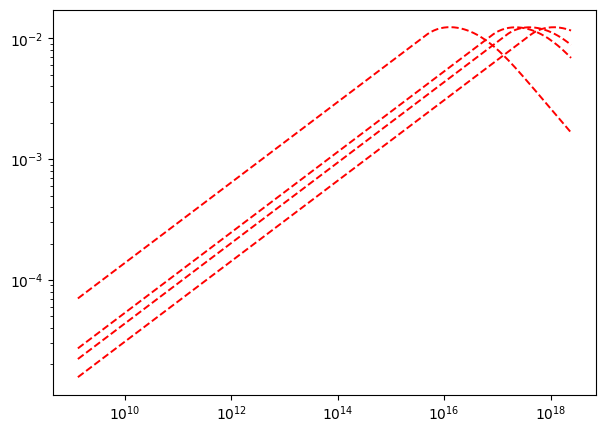

In [ ]:
from matplotlib import colors as mcolors

mcmc_df = pd.read_csv("/home/growth/Documents/GRB250704B/mcmc_df.csv")

x_fit = np.logspace(9.113943352306837, 18.383815365980432, 300)

t_list = [0.5, 1, 1.5, 10]  # days

shifts = {
    "swift": 1,
    "g": 1 / 8,
    "VT_B": 1 / 4,
    "r": 1,
    "i": 8,
    "z": 16,
    "J": 32,
    "10_GHz": 100,
    "1.3_GHz": 400,
    "6_GHz": 300,
    "0.65_GHz": 2000,
}

chain_dict = {
    "6_GHz": "plum",
    "swift": "lavender",
    "g": "mediumaquamarine",
    "r": "coral",  # "tab:red",
    "i": "khaki",
    "z": "peachpuff",
    "J": "tan",
    "10_GHz": "skyblue",
    "1.3_GHz": "plum",
    "0.65_GHz": "b",
}

color_dict = {
    "6_GHz": "magenta",
    "swift": "tab:purple",
    "g": "darkgreen",
    "r": "tab:red",  # "tab:red",
    "i": "darkgoldenrod",
    "z": "peru",
    "J": "olive",
    "10_GHz": "royalblue",
    "1.3_GHz": "plum",
    "0.65_GHz": "b",
}

fig, ax = plt.subplots(figsize=(7, 5))

# color = [color_dict[filt] for filt in freq_dict.keys()]

for t in t_list:
    print(f"Time: {t} days")
    obs_time = t * 86400  # convert to seconds
    med_flux, model_dict = model(t, x_fit, params_median, z)
    ax.plot(
        x_fit,
        med_flux * shifts[filt],
        ls="--",
        color="r",
        lw=1.4,
        # alpha=1,
        zorder=5,
    )
    ax.loglog()


In [ ]:
from matplotlib import colors as mcolors

mcmc_df = pd.read_csv("/home/growth/Documents/GRB250704B/mcmc_df.csv")
times = mcmc_df["Times"].values
freq = dict(
    mcmc_df[["Filt", "Freqs"]]
    .drop_duplicates()
    .sort_values(by="Freqs", ascending=False)
    .to_numpy()
)
freq_dict = dict(freq)
del freq_dict["VT_B"]
del freq_dict["R"]
del freq_dict["VT_R"]
del freq_dict["1.3_GHz"]

# del freq_dict["swift"]
# del freq_dict["g"]
# del freq_dict["i"]
# del freq_dict["r"]
# del freq_dict["z"]
# del freq_dict["J"]
# del freq_dict["10_GHz"]
# del freq_dict["6_GHz"]


shifts = {
    "swift": 1,
    "g": 1 / 8,
    "VT_B": 1 / 4,
    "r": 1,
    "i": 8,
    "z": 16,
    "J": 32,
    "10_GHz": 100,
    "1.3_GHz": 400,
    "6_GHz": 300,
    "0.65_GHz": 2000,
}

chain_dict = {
    "6_GHz": "plum",
    "swift": "lavender",
    "g": "mediumaquamarine",
    "r": "coral",  # "tab:red",
    "i": "khaki",
    "z": "peachpuff",
    "J": "tan",
    "10_GHz": "skyblue",
    "1.3_GHz": "plum",
    "0.65_GHz": "b",
}

color_dict = {
    "6_GHz": "magenta",
    "swift": "tab:purple",
    "g": "darkgreen",
    "r": "tab:red",  # "tab:red",
    "i": "darkgoldenrod",
    "z": "peru",
    "J": "olive",
    "10_GHz": "royalblue",
    "1.3_GHz": "plum",
    "0.65_GHz": "b",
}


x_min = 100
x_max = 2e6
y_min = 1e-6
y_max = 7e2


# fig, ax = plt.subplots(figsize=(6, 4.5))
fig, (ax, ax_freq) = plt.subplots(
    2,
    1,
    figsize=(7, 9),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 0.7], "hspace": 0.05},
)


for filt, freqs in freq_dict.items():
    print(f"Filter: {filt}, Frequencies: {freqs}")
    data_filt = mcmc_df[mcmc_df["Filt"] == filt]
    obs_time = data_filt["Times"].values
    obs_flux = data_filt["Fluxes"].values
    obs_flux_err = data_filt["FluxErrs"].values

    if shifts[filt] == 1:
        label = f"{filt}"
    else:
        label = f"{filt} x {shifts[filt]}"
    if filt == "swift":
        label = "Swift-XRT"

    x_fit = np.logspace(2, 6.2, 300)
    med_flux, model_dict = model(x_fit, freqs, params_median, z)
    for param in params_list:
        Fnu, _ = model(x_fit, freqs, param, z)
        ax.plot(
            x_fit,
            Fnu * shifts[filt],
            ls="-",
            lw=0.6,
            color=chain_dict[filt],
            alpha=0.8,
        )

    ax.errorbar(
        obs_time,
        obs_flux * shifts[filt],
        yerr=obs_flux_err * shifts[filt],
        fmt="o",
        label=label,
        color=color_dict[filt],
        markeredgecolor="k",
    )
    ax.plot(
        x_fit,
        med_flux * shifts[filt],
        ls="--",
        color=color_dict[filt],
        lw=1.4,
        # alpha=1,
        zorder=5,
    )

# upper limit
# filt = "1.3_GHz"
# ax.errorbar(1171802.9, 0.05 * shifts[filt], fmt="v", color=color_dict[filt], markersize=5)


ax.set_ylabel("Flux (mJy)", fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.grid(True, linestyle="--", alpha=0.5)
# ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.legend(fontsize=9, ncol=3, loc="upper left")
param_text = "\n".join([f"{k} = {v:.3g}" for k, v in model_dict.items()])


td = np.linspace(x_min / 86400, x_max / 86400, 1000)  # in days
nu_m = (
    5.1e15
    * (1 + z) ** 0.5
    * ((p - 2) / (p - 1)) ** 2
    * epsilon_e**2
    * epsilon_B**0.5
    * E52**0.5
    * td ** (-1.5)
)  # Hz
nu_c = (
    2.7e12
    * (1 + z) ** (-0.5)
    * epsilon_B ** (-1.5)
    * E52 ** (-0.5)
    * n0 ** (-1)
    * td ** (-0.5)
)  # Hz

nu_a = (
    1.24e9
    * (((p - 1) / (3 * p + 2)) ** (3 / 5))
    * (1 + z) ** (-1)
    * ((p - 2) / (p - 1)) ** (-1)
    * epsilon_e ** (-1)
    * epsilon_B ** (1 / 5)
    * n0 ** (3 / 5)
    * E52 ** (1 / 5)
)

# ax_freq.plot(td, nu_m, label="$\\nu_m$")
# ax_freq.plot(td, nu_c, label="$\\nu_c$")

# Compute frequencies

# Plot frequency evolution
ax_freq.loglog(
    td * 86400, [nu_a] * len(td), label=r"$\nu_a$", lw=1.7, alpha=0.7, color="brown"
)
ax_freq.loglog(td * 86400, nu_m, label=r"$\nu_m$", lw=1.7, alpha=0.7, color="g")
ax_freq.loglog(td * 86400, nu_c, label=r"$\nu_c$", lw=1.7, alpha=0.7, color="black")

# Observing bands
# ax_freq.axhline(y=4.8e14, color='tab:red',
#                 linestyle='--', label=r'r', alpha=0.6)
# ax_freq.axhline(y=2.4e18, color="tab:purple", linestyle='--',
#                 label=r'@10 keV', alpha=0.6)
# ax_freq.axhline(y=1e10, color='teal', linestyle='--', label=r'@10 GHz', alpha=0.6)

# Observing bands
bands = [
    (4.8e14, "r-band", "tab:red"),
    (2.4e18, "@10 keV", "tab:purple"),
    (6e9, "@6 GHz", "magenta"),
]
ymin, ymax = ax_freq.get_ylim()
for yval, label, col in bands:
    ax_freq.axhline(y=yval, color=col, linestyle="--", alpha=0.6)
    x_text = td[-1] * 0.9 * 86400
    y_text = yval + 0.7 * yval  # min(max(yval, ymin*1.1), ymax*0.9)
    ax_freq.text(x_text, y_text, label, color=col, va="bottom", ha="right", fontsize=9)

# Customize frequency plot
ax_freq.set_ylabel("Frequency (Hz)", fontsize=12)
ax_freq.set_xlabel("Time since trigger (s)", fontsize=12)
ax_freq.grid(alpha=0.3)
ax_freq.set_yscale("log")
ax_freq.set_xscale("log")
# limit y axis
ax_freq.set_ylim(None, 1e20)
ax_freq.legend(fontsize=9, ncol=3, loc="upper left")

plt.tight_layout()

fig.savefig(
    "/home/growth/Desktop/modelled_lc.png",
    dpi=300,
    format="png",
    bbox_inches="tight",
)
